In [ ]:
!python --version


Python 3.7.13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

**Read in the dataset and check the first 5 rows**

In [ ]:
data = pd.read_csv('/content/dementia_dataset.csv')

In [ ]:
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


# **Exploratory Data Analysis**

**Drop the default columns, which are the Subject ID, MRI ID, Hand, and converte the 'M/F' column name to 'Sex'**

In [ ]:
data.drop(['Subject ID', 'MRI ID', 'Hand'], axis = 1, inplace=True) #Remove default columns

In [ ]:
data = data.rename(columns = {'M/F':'Sex'}) #rename the M/F column to Sex

**change the categorical columns to numeric columns such that; ('Nondemented'= 0,'Demented' = 1, 'Converted' = 2) - with respect to the 'Group' column and ('M' = 1, 'F' = 0) - with respect to the 'Sex' column.**

In [ ]:
#Create a dictionary to map the categorical values to numeric
group_mapp = {'Nondemented':0,'Demented':1, 'Converted':2} 
sex_mapp = {'M':1, 'F':0}


data.Group = data.Group.map(group_mapp) #Perform the mapping
data.Sex = data.Sex.map(sex_mapp)

**Check for missing values**

In [ ]:
data.isnull().sum()

Group        0
Visit        0
MR Delay     0
Sex          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

In [ ]:
#Check if the missing values are from the NonDemented category
data[data['Group']== 0].isnull().sum() 

Group       0
Visit       0
MR Delay    0
Sex         0
Age         0
EDUC        0
SES         0
MMSE        0
CDR         0
eTIV        0
nWBV        0
ASF         0
dtype: int64

In [ ]:
#Check if the missing values are from the Demented category; which they are
data[data['Group']== 1].isnull().sum()

Group        0
Visit        0
MR Delay     0
Sex          0
Age          0
EDUC         0
SES         19
MMSE         2
CDR          0
eTIV         0
nWBV         0
ASF          0
dtype: int64

**impute the missing values in 'MMSE' with the median of the demented group (since all missing values in MMSE were from 'Demented' category of the 'Group' column) and imputed the missing values in 'SES' with the mode of the 'Demented' group.**

In [ ]:
#Check the Median and Mode of the MMSE and SES columns based on the Demented category
mmse_med = data[data['Group']== 1]['MMSE'].median()
ses_mean = data[data['Group']== 1]['SES'].mode()[0]

In [ ]:
#Fill the missing values in MMSE with the median of the demented group
data.MMSE.fillna(mmse_med, inplace =True) 

#Fill the missing values in SES with the mode of the demented group
data.SES.fillna(ses_mean, inplace =True) 

**Check the heatmap of the dataset based on the corr between features and output**

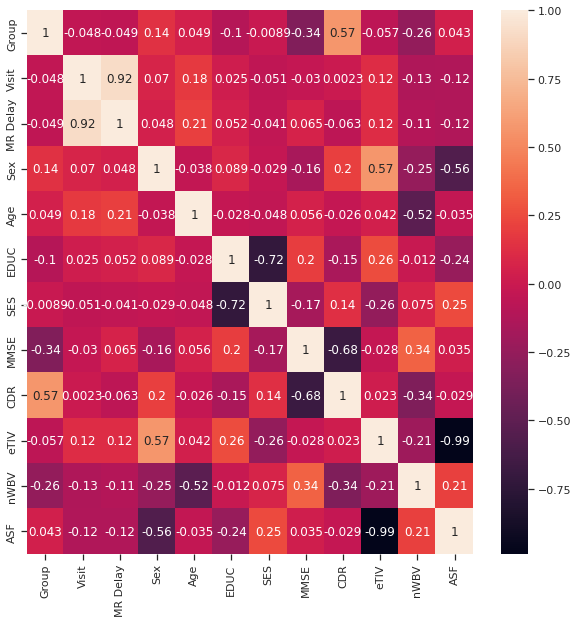

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data.corr(), annot = True);
# plt.savefig('corr_plot.png', dpi=100, bbox_inches='tight')

**Observations fron the heat map**

- From the heat map it is interpreted that, the dementia classification group exhibits the highest positive correlation with `CDR` and also exhibits relatively high positive correlation with the `age` of the subject.


- The dementia classification group exhibits the highest negative correlation with `MMSE` score of the subject and also exhibits relatively high negative correlation with the `sex`, `education level`, and the `nWBV` of the subject.


**Hence, the following features were considered for the prediction model:**
  
      - Sex.

      - Age.

      - Education level.

      - Mini-mental state examination score.

      - Clinical dementia rating.

      - Normalized whole brain volume.

      - Estimated total intercranial volume

**Drop the unwanted Columns**

In [ ]:
data = data.drop(['Visit', 'SES', 'MR Delay', 'ASF'], axis = 1)

**Checking for outliers**

In [ ]:
def plot_boxplot(df, ft):
  df.boxplot(column=[ft])
  plt.grid(False)
  plt.show()

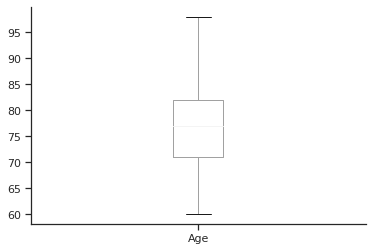

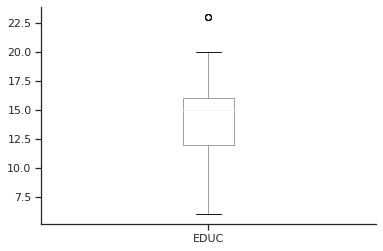

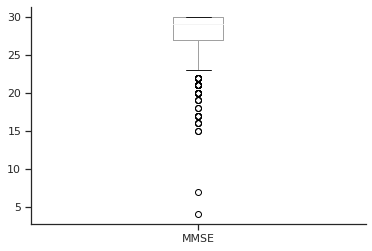

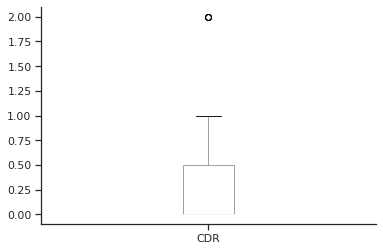

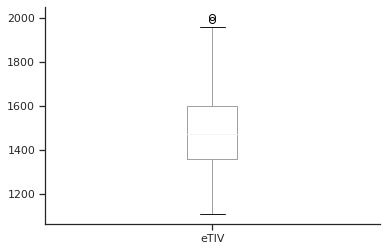

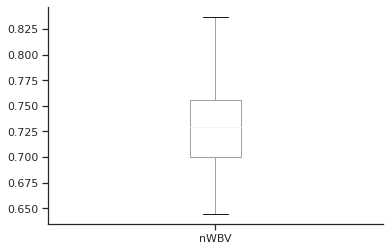

In [ ]:
features = ['Age', 'EDUC', 'MMSE', 'CDR', 'eTIV', 'nWBV']
for feat in features:
  plot_boxplot(data, feat)
  print("\n\n")

**Observations on Outliers**

- There are no outliers in the 'Age' and 'nWBV' column
- Outliers in the other columns (EDUC, MMSE, eTIV) will be removed except for those in the 'CDR' columns
- We are excepting CDR because the outlier refers to a rare case of dementia which explains why it was categorized as an outlier

**Removing Outliers**

In [ ]:
#Create a function that returns a list containing all the index of outliers based on interquatile range
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound) ]

  return ls

In [ ]:
#Create an empty list to store the output indices from multiple columns
index_list = []
for feature in ['EDUC', 'MMSE', 'eTIV']:
  index_list.extend(outliers(data, feature))

In [ ]:
len(index_list)

47

In [ ]:
# Define a function to remove the outliers and returns a cleaned dataframe without outliers
def remove(df, ls):
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df

In [ ]:
data_clean = remove(data,index_list)

### **Visualizations**

**Show the count_plot for each category in the Group column**

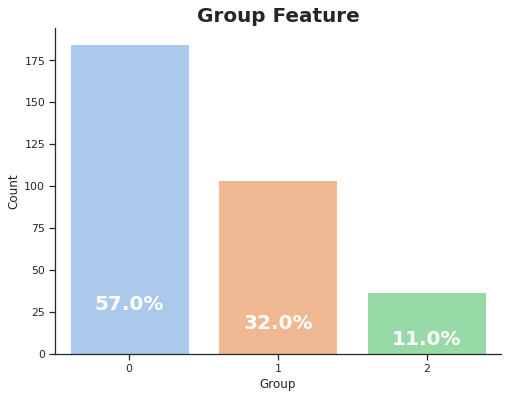

<Figure size 432x288 with 0 Axes>

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='pastel')
fig = plt.figure ( figsize= (8,6) )
ax=sns.countplot(data=data_clean, x='Group')
for i in ax.patches:
    ax.text(x=i.get_x()+i.get_width()/2, y=i.get_height()/7, s=f"{np.round(i.get_height()/len(data_clean)*100,0)}%", ha='center', size=20, weight='bold', rotation=360, color='white')
plt.title("Group Feature", size=20, weight='bold')
plt.ylabel ( 'Count' )
plt.show()
plt.savefig('clean_count_plot.png', bbox_inches='tight')

**Show the distribution of the Group column by sex**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


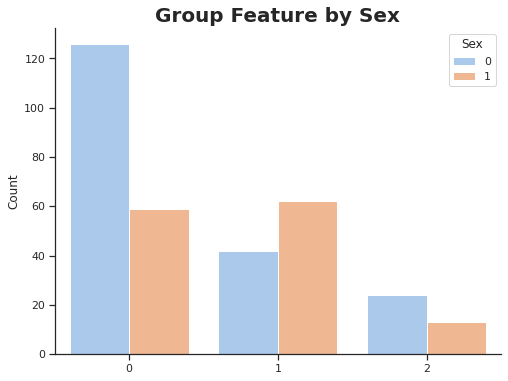

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure ( figsize= (8,6) )
sns.countplot ( data_clean.Group, data=data_clean, hue='Sex' )
plt.title("Group Feature by Sex", size=20, weight='bold')
plt.ylabel ( 'Count' )
plt.xlabel ('', size = 16 )
plt.show()
plt.savefig('group_by_sex.png', dpi=100, bbox_inches='tight')

**Save the clean data in a csv file**

In [ ]:
data_clean.to_csv('/content/clean_dementia_dataset.csv',index = False)

**Normalized the dataset and split to train and test set**

In [ ]:
X = data_clean.drop('Group', axis = 1) #Create the X features by droping the output column of the clean dataset
y = data_clean['Group'] #Create the y output by selecting the Output column of the clean dataset

In [ ]:
scaler = StandardScaler() #create an object of StandardScaler
X_norm = pd.DataFrame(scaler.fit_transform(X), columns = X.columns) #transform the X features by calling the 'fit_transform' method 

In [ ]:
X_norm.head()

,Sex,Age,EDUC,MMSE,CDR,eTIV,nWBV
0,1.197011,-0.273032,-0.944050,-3.009412,0.903785,1.109133,0.043781
1,1.197011,-0.138375,-0.944050,-0.223869,0.903785,1.451072,-0.592399
2,-0.835414,1.477510,1.185779,-0.223869,-0.715083,-1.529494,-0.675379
3,-0.835414,1.746824,1.185779,-0.780978,-0.715083,-1.614979,-0.454099
4,1.197011,0.400254,-0.944050,-0.223869,-0.715083,1.171822,-0.620059


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size = 0.2, random_state = 1, stratify = y) 

# **Model Training and Evaluation**

In [ ]:
classifiers = [ LogisticRegression(random_state=42), SVC (random_state=42),
       RandomForestClassifier(random_state=42), XGBClassifier(random_state=42) ]
model_names = [ 'Logistic Regression', 'Support vector machine', 'Random Forest', 'XGradient boost' ]


In [ ]:
#Define a function to teat the performace of different models 
def train_val_models(classifiers, model_names, X_train,y_train, X_test, y_test):

  reports = []

  for clf, model in zip(classifiers,model_names):
    clf.fit ( X_train, y_train )
    y_pred = clf.predict (X_test)
    report = classification_report(y_test, y_pred)
    reports.append(report)

  return model_names, reports

In [ ]:
model_names, reports = train_val_models(classifiers, model_names, X_train,y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for name,report in zip(model_names,reports):
  print(name)
  print(report)
  print("\n\n")

Logistic Regression
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        37
           1       0.88      1.00      0.93        21
           2       0.00      0.00      0.00         8

    accuracy                           0.88        66
   macro avg       0.59      0.67      0.62        66
weighted avg       0.77      0.88      0.82        66




Support vector machine
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        37
           1       0.91      1.00      0.95        21
           2       1.00      0.12      0.22         8

    accuracy                           0.89        66
   macro avg       0.93      0.71      0.70        66
weighted avg       0.91      0.89      0.86        66




Random Forest
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        37
           1       0.95      1.00      0.98        21
           2

**Observation**

Random Forest Classifier apears to be the best performing model

**Training an Random Forest Model**

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Print Classification Report for training data
target_names = ['Demented', 'Non Demented', 'Converted']
print(classification_report(y_train, model.predict(X_train), target_names=target_names))

              precision    recall  f1-score   support

    Demented       1.00      1.00      1.00       148
Non Demented       1.00      1.00      1.00        83
   Converted       1.00      1.00      1.00        29

    accuracy                           1.00       260
   macro avg       1.00      1.00      1.00       260
weighted avg       1.00      1.00      1.00       260



In [ ]:
#Print Classification Report for test data
target_names = ['Demented', 'Non Demented', 'Converted']
print(classification_report(y_test, model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

    Demented       0.88      1.00      0.94        37
Non Demented       0.95      1.00      0.98        21
   Converted       1.00      0.25      0.40         8

    accuracy                           0.91        66
   macro avg       0.95      0.75      0.77        66
weighted avg       0.92      0.91      0.88        66



**Show confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

Number of records in the test dataset: 66



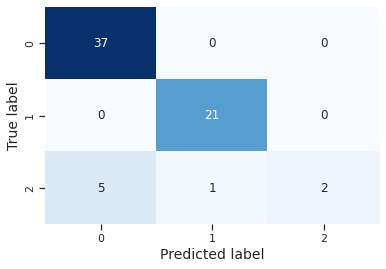

In [ ]:
conf_matrix = confusion_matrix (  y_test, model.predict(X_test) )

print ('Number of records in the test dataset: %d\n' %y_test.shape[0])

# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
#plot 1
sns.heatmap(conf_matrix,annot=True, cmap='Blues', cbar=False, fmt='d')
plt.xlabel('Predicted label', size = 14)
plt.ylabel('True label', size = 14)
plt.savefig('conf_matrix.png', dpi=100, bbox_inches='tight')

**Save the Model**

In [ ]:
import pickle

In [ ]:
with open("dementia_model.pkl", "wb") as f:
  pickle.dump(model,f)

'0.90'